In [16]:
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

In [17]:
# List the debug files
files = glob.glob('debug*.npz')
print(len(files), 'files found')
files.sort()

thetas = []
dndz_ph_bins = []
z_ph = []
# Load the data
for file in files:
    data = np.load(file)
    thetas.append(data['theta'])
    dndz_ph_bins.append(data['dndz_ph_bins'])
    z_ph.append(data['z_ph'])
    ells = data['ells']

#assert all([np.allclose(z_ph[0], z_ph[i]) for i in range(1, len(z_ph))])
z_ph = z_ph[0]

31 files found


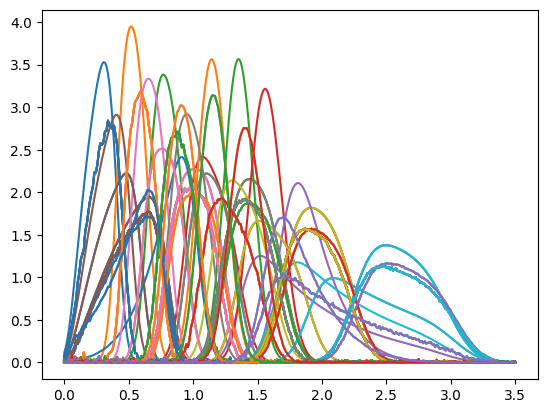

In [117]:
# Plot the dndz_ph_bins
plt.figure()
for k in range(len(thetas)):
    for i in range(len(dndz_ph_bins[k])):
        plt.plot(z_ph, dndz_ph_bins[k][i])

In [80]:
# Reshape thetas in a 2D array
thetas = np.array(thetas)
thetas = thetas.reshape((len(thetas), -1))
print(thetas.shape)

(6, 10)


In [81]:
print(thetas)

[[ 2.61768705e-01  6.14711695e-02  6.86722633e-01  8.55731469e-01
   1.04242374e+00  2.44050225e-03 -2.45017432e-03  3.93863862e-03
  -4.37709051e-03 -4.11191874e-03]
 [ 4.05877309e-01  3.29596321e-02  1.02830484e+00  8.94653662e-01
   7.76869082e-01 -4.01995921e-03  3.71140124e-03 -1.59030051e-03
  -5.12098540e-04 -4.00732686e-03]
 [ 2.99413943e-01  5.95096287e-02  7.43093470e-01  8.62171269e-01
   9.46787357e-01 -2.35764025e-03  1.53731017e-03  9.79189267e-04
   6.53869203e-04 -4.33004928e-03]
 [ 2.02427809e-01  6.27062998e-02  5.01237553e-01  9.50625888e-01
   1.13526365e+00 -7.79988868e-04 -4.06266817e-03  4.02268101e-03
  -4.18647768e-03  1.53584568e-03]
 [ 2.61885500e-01  4.11084489e-02  1.03850653e+00  6.78273187e-01
   9.08835257e-01  4.49503235e-03  2.24763776e-03 -1.36458737e-03
  -2.65653480e-03 -4.36150974e-03]
 [ 3.41830340e-01  7.46294583e-02  9.09454741e-01  7.15280969e-01
   8.43496478e-01  2.89239011e-03 -1.33724599e-03 -1.20363980e-03
   1.07347352e-03 -4.44808999e-03

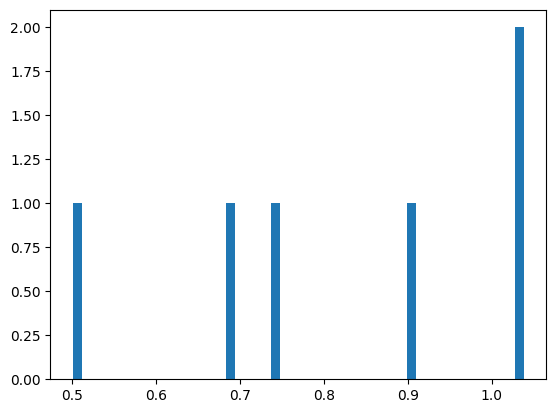

In [86]:
# Plot the distribution of theta values
plt.figure()
plt.hist(thetas[:,2], bins=50);

In [42]:
# Delete debug files
for file in files:
    os.remove(file)

Original mean: 0.9871038858999953
Directly shifted mean: 1.0071038858999952
Mean from interpolated dndz: 1.0056750820747031
Mean from shifted z vector: 1.007103885899995


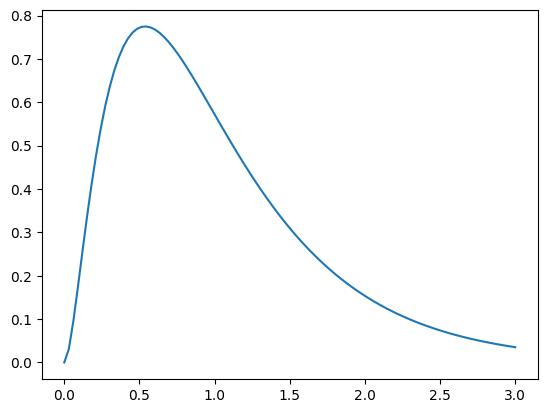

In [41]:
from scipy.interpolate import InterpolatedUnivariateSpline
import numpy as np

def pz_error(z, dndz, mu):
    z_shift=z + mu
    
    spline = InterpolatedUnivariateSpline(z_shift, dndz, k=1, ext=1)
    new_dndz = spline(z)
    new_dndz[new_dndz<0]=0
    return new_dndz

def shift_mean(z, dndz, delta_z=0.02):
    '''
    Shift the mean redshift of the distribution.
    Args:
    z: redshift (array-like)
    dndz: redshift distribution (array-like)
    delta_z: shift in the mean redshift (float)
    '''
    mean_z = np.average(z, weights=dndz)
    #delta_z *= (1 + mean_z)
    z_shift = z + delta_z
    # Ensure the redshift distribution is non-negative.
    # Clip to a very small value instead of zero 
    # to avoid division by zero
    for i in range(len(z_shift)):
        if z_shift[i] <= 0:
            z_shift[i] = 1e-4*i
    return z_shift

# Define redshift vector and dndz
z = np.linspace(0, 3, 100)
#dndz = np.exp(-0.5*((z-1.5)/0.2)**2) # Gaussian
# Smail
dndz = z**2 * np.exp(-(z/0.11)**0.68) # Smail
dndz /= np.trapz(dndz, z) # Normalise

plt.plot(z, dndz)

# compute mean z of distribution
mean_z = np.average(z, weights=dndz)
print('Original mean:', mean_z)

# compute shifted mean based on delta_z*(1+z)
mean_z_shift = mean_z + 0.02#*(1 + mean_z)
print('Directly shifted mean:', mean_z_shift)

# shift mean by 0.002
new_dndz = pz_error(z, dndz, 0.02)
new_mean_z = np.sum(z*new_dndz)/np.sum(new_dndz)
print('Mean from interpolated dndz:', new_mean_z)

z_shift = shift_mean(z, dndz, 0.02)
new_mean_z = np.sum(z_shift*dndz)/np.sum(dndz)
print('Mean from shifted z vector:', new_mean_z)

In [26]:
dndz_shift = pz_error(z, dndz, 0.02)
mean_original = np.sum(z*dndz)/np.sum(dndz)
mean_shifted = np.sum(z*dndz_shift)/np.sum(dndz_shift)
print('Difference in mean:', mean_shifted - mean_original)

Difference in mean: 0.020107551617357555
